In [1]:
from transformers import pipeline
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from rich import print
import torch


In [3]:
# torch.cuda.is_available()
torch.cuda.current_device()


0

In [1]:
# # https://www.kaggle.com/crowdflower/twitter-airline-sentiment
# !wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv


In [5]:
data = pd.read_csv("./AirlineTweets.csv")
# reduce the sentiment to two choices
# ositive and negative
data_minus_neutral = data.loc[data.airline_sentiment != "neutral", :].copy()


In [5]:
# Basic usage of hugginface pipeline
classifier = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [11]:
print(type(classifier))


<class 'transformers.pipelines.text_classification.TextClassificationPipeline'>

In [12]:
# basic usage of the classifier pipeline
# it returns a dictionary of score and label for each input texts. It returns a list of these dicts if a list of input texts was passed as an argument.
classifier(" I am not sure if I will buy it from them")


[{'label': 'NEGATIVE', 'score': 0.9994786381721497}]

In [14]:
# Multiple inputs passed in as a list
print(classifier([
  "This course is just what I needed.",
  "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What are prerequisites? Why does he keep saying that?"
]))


[{'label': 'POSITIVE', 'score': 0.9991594552993774}, {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

In [4]:
# use the GPU
classifier = pipeline("sentiment-analysis", device = 0)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


<Axes: >

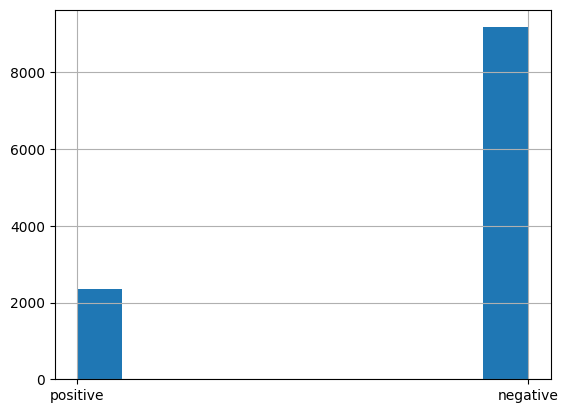

In [6]:
data_minus_neutral.airline_sentiment.hist() # An imbalance dataset


In [11]:
data_minus_neutral.shape


(11541, 16)

In [7]:
texts = data_minus_neutral.text.tolist()
predictions = classifier(texts)


In [8]:
target_map = {'positive': 1, 'negative': 0}
data_minus_neutral['target'] = data_minus_neutral['airline_sentiment'].map(target_map)


In [12]:
print(predictions[:5])


[
    {'label': 'POSITIVE', 'score': 0.6070840954780579},
    {'label': 'NEGATIVE', 'score': 0.9973449110984802},
    {'label': 'NEGATIVE', 'score': 0.9995823502540588},
    {'label': 'NEGATIVE', 'score': 0.9854250550270081},
    {'label': 'POSITIVE', 'score': 0.9553212523460388}
]

In [13]:
"""
We have to compute metrics such as auc beacause the data is imbalance.
So ltes make our probability consistent. Lets all the predictions be a probability of
positive sentiment.
"""
probs = [d['score'] if d['label'].startswith("P") else 1 - d['score'] for d in predictions]
print(probs[:5])


[0.6070840954780579, 0.0026550889015197754, 0.0004176497459411621, 0.014574944972991943, 0.9553212523460388]

In [14]:
preds = [1 if d['label'].startswith("P") else 0 for d in predictions]
preds = np.array(preds)
preds.shape


(11541,)

In [15]:
# compute accuracy
accuracy = np.mean(data_minus_neutral.target == preds)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8898708950697514

In [16]:
cm = confusion_matrix(data_minus_neutral['target'], preds, normalize='true')
cm


array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

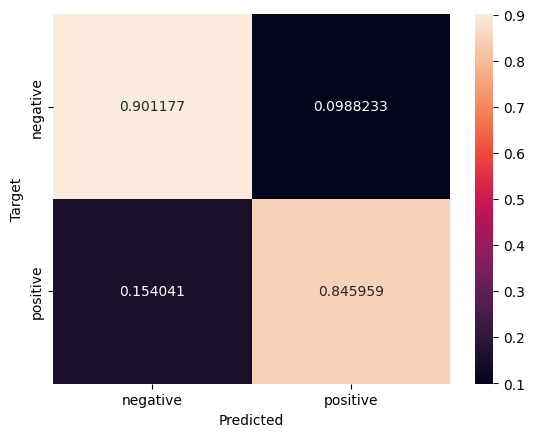

In [17]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)


In [25]:
# it depends on which label we asign 1 and which one we assign 0
# That is it depends on the meaning of the label
# this is demonstrated in the next cell
# where we have inverted the label
f1_score(data_minus_neutral['target'], preds)


0.7587777566900741

In [26]:
f1_score(1 - data_minus_neutral['target'], 1 - preds)


0.928647616908999

In [23]:
roc_auc_score(data_minus_neutral['target'], probs)


0.9485934690648773

In [24]:
roc_auc_score(1 - data_minus_neutral['target'], 1 - np.array(probs))


0.9485934690648772